In [572]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
import sys
sys.path.insert(0, r'../../../quetzal')

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

from syspy.spatial.spatial import nearest
from quetzal.engine.pathfinder_utils import sparse_matrix, parallel_dijkstra, simple_routing
from syspy.clients.api_proxy import get_distance_matrix
import random as random
from quetzal.engine.road_model import RoadModel, plot_correlation
from shapely.geometry import Point
plot=True

In [573]:
training_folder = '../../'
input_folder = training_folder + r'inputs/'
output_folder = training_folder + r'outputs/'

# import

In [574]:
zones = gpd.read_file(r'../../inputs/zones/zones.geojson')


In [575]:
links = gpd.read_file(input_folder + 'road/road_links.geojson'.format(s=scenario))
links.set_index('index',inplace=True)
nodes = gpd.read_file(input_folder + 'road/road_nodes.geojson'.format(s=scenario))
nodes.set_index('index',inplace=True)

# add freeflow speed and time

In [576]:
links = links.rename(columns={'speed':'speed_ff','time':'time_ff'})

# init RoadModel

In [577]:
self = RoadModel(links,nodes,zones,ff_time_col='time_ff')

In [578]:
#find zones centroid and closest road_nodes
self.zones_nearest_node()

max_distance found:  0.004759333134373134 degrees


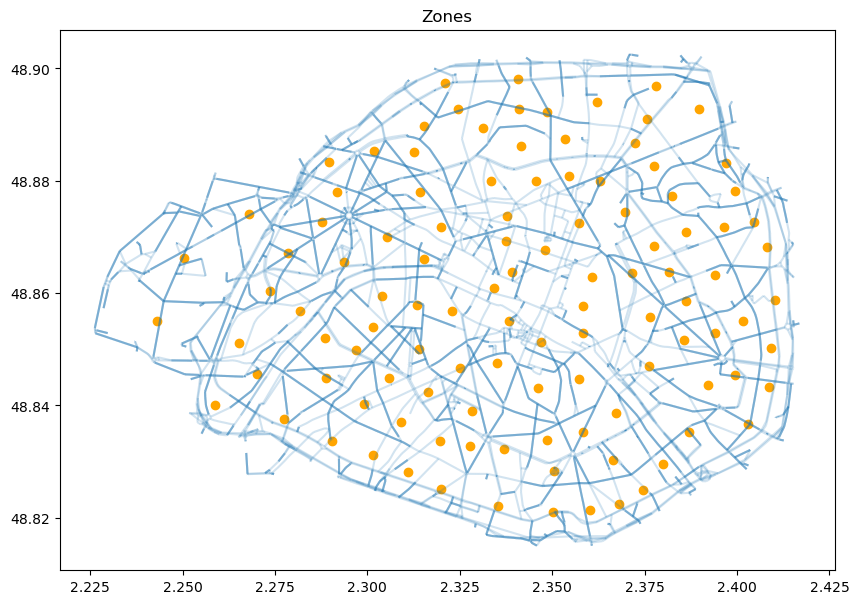

In [579]:
if plot:
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(10,10))
    self.road_links.plot(ax=ax,alpha=0.2)
    self.zones_centroid.plot(ax=ax,color='orange')
    plt.title('Zones')
    #plt.savefig(figdir +'/zones.png')

In [580]:
self.create_od_mat()

# API call

In [581]:
print(len(self.od_time),'OD')
print(len(self.zones_centroid), 'zones')

11990 OD
110 zones


In [582]:
train_od = self.get_training_set(train_size=30,seed=42)

11099  OD to interpolate
891  OD for training (API call)
8.0 % training
number of unique origin and destination in training set
110 110
max destination for an origin: 15


In [583]:
hereApiKey= ''   
#read Here matrix
try:
    mat = pd.read_csv(output_folder + 'road/here_OD.csv')
    mat = mat.set_index('origin')
    mat.columns.name='destination'
except:
    mat = self.call_api_on_training_set(train_od,
                                         apiKey=hereApiKey,
                                         api='here',
                                         mode='car',
                                         time='2022-12-13T08:00:21+01:00')
    mat.to_csv(output_folder + 'road/here_OD.csv')

In [584]:
self.apply_api_matrix(mat)

0 unfound OD in the api call, they will be interpolated
od time applied on 891
od to interpolate 11099


# KNN interpolation

In [585]:
self.train_knn_model(weight='distance', n_neighbors=5)

In [586]:
self.predict_zones()

In [587]:
self.od_time

,origin,destination,time_ff,o_lon,o_lat,d_lon,d_lat,time,interpolated,residual
1,25554243,9074748722,248.819040,2.333396,48.860100,2.339768,48.863541,335.958997,True,87.139957
2,25554243,25207334,298.964400,2.333396,48.860100,2.336775,48.869537,522.147064,True,223.182664
3,25554243,470200,338.769360,2.333396,48.860100,2.347307,48.867370,535.844742,True,197.075382
4,25554243,94137863,323.373600,2.333396,48.860100,2.359609,48.864682,521.357437,True,197.983837
5,25554243,368142,297.665040,2.333396,48.860100,2.357816,48.853333,447.000000,False,149.334960
...,...,...,...,...,...,...,...,...,...,...
12094,148944071,96127099,248.103240,2.394507,48.864688,2.395760,48.870091,294.217706,True,46.114466
12095,148944071,174981131,202.474380,2.394507,48.864688,2.386192,48.868526,289.840626,True,87.366246
12096,148944071,1771585813,368.963556,2.394507,48.864688,2.411193,48.849734,502.966463,True,134.002907
12097,148944071,2282290896,376.865760,2.394507,48.864688,2.409830,48.858709,370.906978,True,-5.958782


# apply OD mat to road network

In [588]:
%%time
err = self.apply_od_time_on_road_links(num_it=15, num_cores=1, max_speed=100,log_error=True)


0 4.53
1 1.45
2 1.29
3 1.22
4 1.17
5 1.14
6 1.13
7 1.11
8 1.1
9 1.09
10 1.08
11 1.07
12 1.06
13 1.06
14 1.05
15 1.05
74.0 % of links used
CPU times: user 5.53 s, sys: 76.6 ms, total: 5.61 s
Wall time: 5.59 s


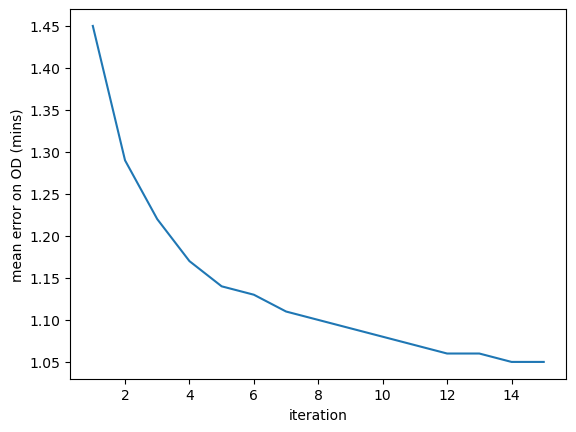

In [589]:
if plot:
    %matplotlib inline
    plt.plot([x[0] for x in err[1:]],[x[1] for x in err[1:]])
    plt.xlabel('iteration')
    plt.ylabel('mean error on OD (mins)')
    #plt.savefig(figdir +'/error.png')

Mean Absolute Error: 1.05 mins.


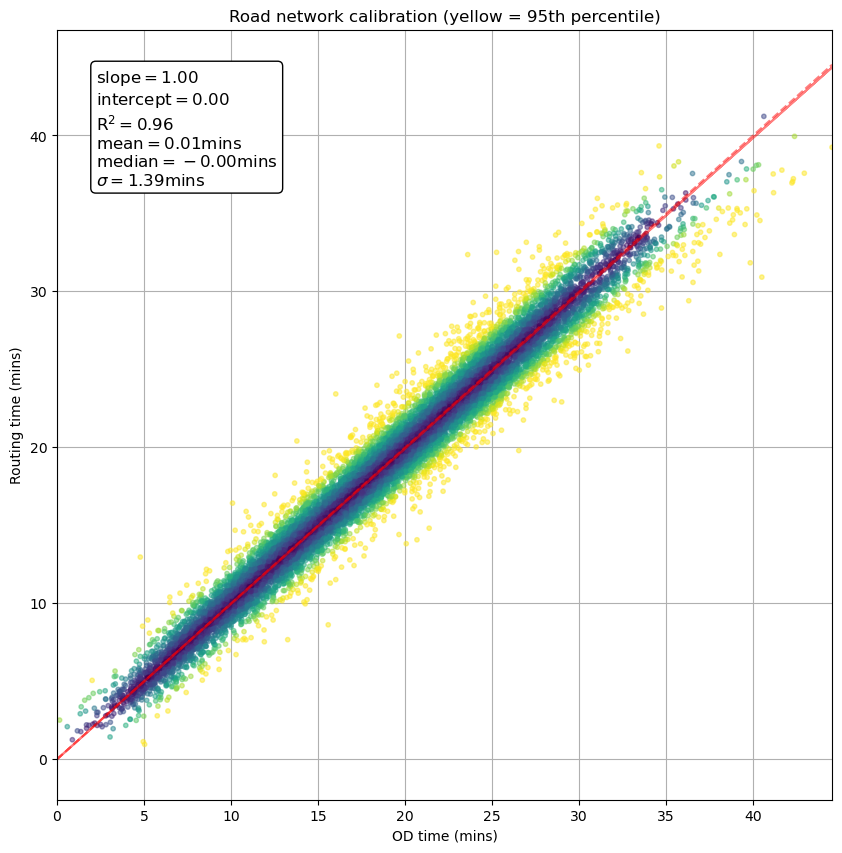

In [590]:
if plot:
    plot_correlation(self.od_time['time']/60, 
                     self.od_time['routing_time']/60, 
                     alpha=0.5,
                     xlabel='OD time (mins)', 
                     ylabel='Routing time (mins)',
                     title = 'Road network calibration (yellow = 95th percentile)')
    #plt.savefig(figdir + 'road_calibration.png')

# export

In [591]:
self.road_links.to_file(output_folder + 'road/road_links.geojson',driver='GeoJSON')
self.road_nodes.to_file(output_folder + 'road/road_nodes.geojson',driver='GeoJSON')

In [610]:
output_folder

'../../outputs/'

In [592]:
from shapely.geometry import Point, LineString
def to_linestring(df):
    ls=[]
    for row in df:
        line = LineString([Point(row[0], row[1]), Point(row[2], row[3])])
        ls.append(line)
    return ls

train_df = self.od_time[~self.od_time['interpolated']]
interp_df = self.od_time[self.od_time['interpolated']]

geom = to_linestring(train_df[['o_lon','o_lat','d_lon','d_lat']].values)
train_df = gpd.GeoDataFrame(train_df,geometry=geom,crs=4326)

geom = to_linestring(interp_df[['o_lon','o_lat','d_lon','d_lat']].values)
interp_df = gpd.GeoDataFrame(interp_df,geometry=geom,crs=4326)


In [593]:
random.seed(42)
random_od = random.sample(range(0, len(self.zones)), 2)
random_od

[81, 14]

In [594]:
origin = self.zones.iloc[random_od[0]].name
destination = self.zones.iloc[random_od[1]].name
o_node = self.zones_centroid.loc[origin]['node_index']
d_node = self.zones_centroid.loc[destination]['node_index']
self.zones_centroid.loc[[origin,destination]]

,area,emp,emp_dens,id,name,pop,pop_dens,geometry,node_index
index,,,,,,,,,
zone_82,599498.353451,14403.54744,24026,83,83,24460.132319,40801,POINT (2.31255 48.88514),2925129353
zone_14,566682.463182,6727.08752,11871,15,15,12516.315564,22087,POINT (2.31404 48.85000),65308763


In [595]:
test = interp_df[(interp_df['origin']==o_node) & (interp_df['destination']==d_node)]
test

,origin,destination,time_ff,o_lon,o_lat,d_lon,d_lat,time,interpolated,residual,routing_time,geometry
8924,2925129353,65308763,924.62328,2.312563,48.887699,2.314539,48.850539,837.495883,True,-87.127397,985.499375,"LINESTRING (2.31256 48.88770, 2.31454 48.85054)"


In [596]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_df[['o_lon','o_lat','d_lon','d_lat']].values)
indices =  nbrs.kneighbors(test[['o_lon','o_lat','d_lon','d_lat']],return_distance=False)
indices = pd.DataFrame(indices)
#distances = pd.DataFrame(distances)
indices = pd.DataFrame(indices.stack(), columns=['index_nn']).reset_index().rename(
    columns={'level_0': 'ix_one', 'level_1': 'rank'})
# drop duplicates (if 100 is neigh to 1, 1 will be neigh to 100, remove all values like that)
# as the index are sorted, index_nn should always be larger than ix_one
indices = indices.loc[(indices['index_nn']>indices['ix_one']).values]

In [597]:
voisin = train_df.iloc[indices['index_nn'].values]


In [598]:
vtime = voisin['time'].values/60
vtime = [round(time) for time in vtime]
itime = round(test['time'].values[0]/60)

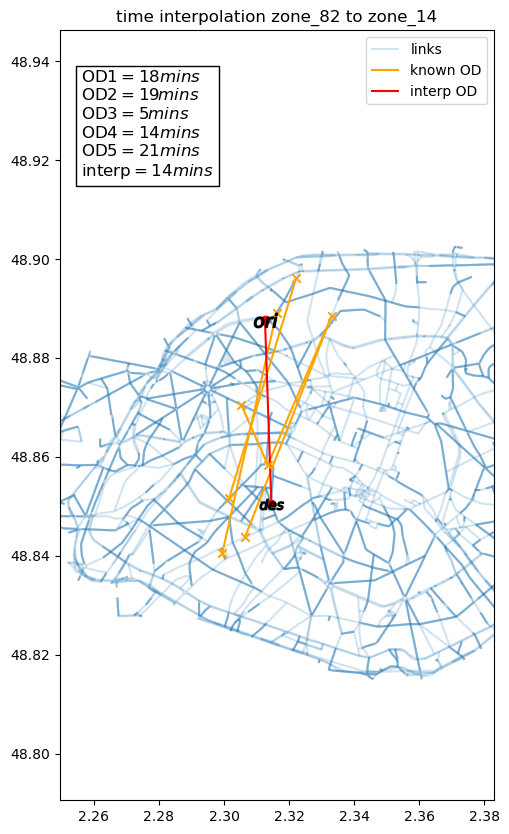

In [599]:
plot=True
if plot:
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(10,10))
    self.road_links.plot(ax=ax,alpha=0.2,zorder=1)
    voisin.plot(ax=ax,alpha=1,zorder=5,color='orange')
    test.plot(ax=ax,alpha=1,zorder=5,color='red')

    self.road_nodes.loc[self.zones_centroid[self.zones_centroid['node_index'].isin(voisin['origin'].values)]['node_index'].values].plot(color='orange',marker='x',ax=ax,zorder=9)
    self.road_nodes.loc[self.zones_centroid[self.zones_centroid['node_index'].isin(voisin['destination'].values)]['node_index'].values].plot(color='orange',marker='x',ax=ax,zorder=9)
    self.road_nodes.loc[self.zones_centroid.loc[[origin,destination]]['node_index'].values].plot(color='r',ax=ax,zorder=8)
    self.road_nodes.loc[self.zones_centroid.loc[[origin]]['node_index'].values].plot(color='k',ax=ax,zorder=9,marker='$ori$',markersize=300)
    self.road_nodes.loc[self.zones_centroid.loc[[destination]]['node_index'].values].plot(color='k',ax=ax,zorder=9,marker='$des$',markersize=300)
    xmax = voisin[['o_lon','d_lon']].max().max()+0.05
    xmin = voisin[['o_lon','d_lon']].min().min()-0.05
    ymax = voisin[['o_lat','d_lat']].max().max()+0.05
    ymin = voisin[['o_lat','d_lat']].min().min()-0.05
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.legend(['links','known OD','interp OD'])

    textstr = '\n'.join((
    r'$\mathrm{OD1 }=%.fmins$' % (vtime[0], ),
    r'$\mathrm{OD2 }=%.fmins$' % (vtime[1], ),
    r'$\mathrm{OD3 }=%.fmins$' % (vtime[2], ),
    r'$\mathrm{OD4 }=%.fmins$' % (vtime[3], ),
    r'$\mathrm{OD5 }=%.fmins$' % (vtime[4], ),
    r'$\mathrm{interp }=%.fmins$' % (itime, ),))
# these are matplotlib.patch.Patch properties
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    plt.title('time interpolation {i} to {j}'.format(i=origin,j=destination))
    #plt.savefig(figdir+'knn_example.png')
    #centroid.plot(color='r',ax=ax)


# routing example

In [600]:
time_mat, predecessors, node_index = simple_routing([o_node],[d_node],self.road_links,weight_col='time',return_predecessors=True)
reversed_index = {v: k for k, v in node_index.items()}

In [601]:
from quetzal.engine.pathfinder_utils import get_path
path = get_path(predecessors, 0, node_index[d_node])
path = list(zip(path[:-1], path[1:]))


path = [(reversed_index[k[0]], reversed_index[k[1]]) for k in path]
links_dict = self.road_links.reset_index().set_index(['a','b'])['index'].to_dict()
path = [*map(links_dict.get,path)]


In [602]:
route = self.road_links.loc[path]
hull = route.unary_union.convex_hull
xx, yy = hull.exterior.coords.xy

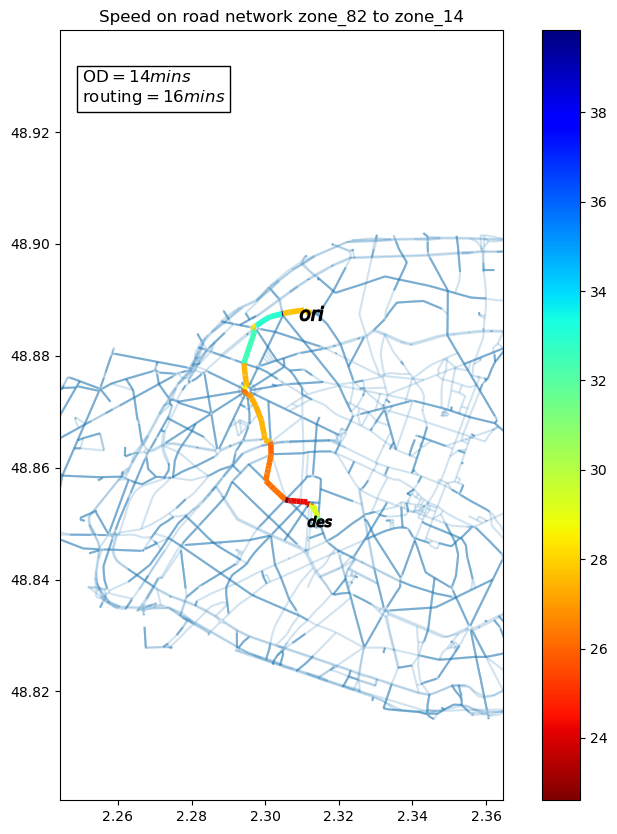

In [603]:
if plot:
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(10,10))
    self.road_links.plot(ax=ax,alpha=0.2)
    self.road_links.loc[path].plot(ax=ax,column='speed',legend=True,linewidth=4,cmap='jet_r')
    self.road_nodes.loc[[o_node]].plot(color='k',ax=ax,zorder=8,marker='$ori$',markersize=300)
    self.road_nodes.loc[[d_node]].plot(color='k',ax=ax,zorder=8,marker='$des$',markersize=300)

    xmax = max(xx)+0.05
    xmin = min(xx)-0.05
    ymax = max(yy)+0.05
    ymin = min(yy)-0.05
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])

    textstr = '\n'.join((
        r'$\mathrm{OD }=%.fmins$' % (test['time'].values[0]/60, ),
        r'$\mathrm{routing }=%.fmins$' % (test['routing_time'].values[0]/60, ),))
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    plt.title('Speed on road network {i} to {j}'.format(i=origin,j=destination))
    #plt.savefig(figdir + 'routing_example.png')

# road_links plots

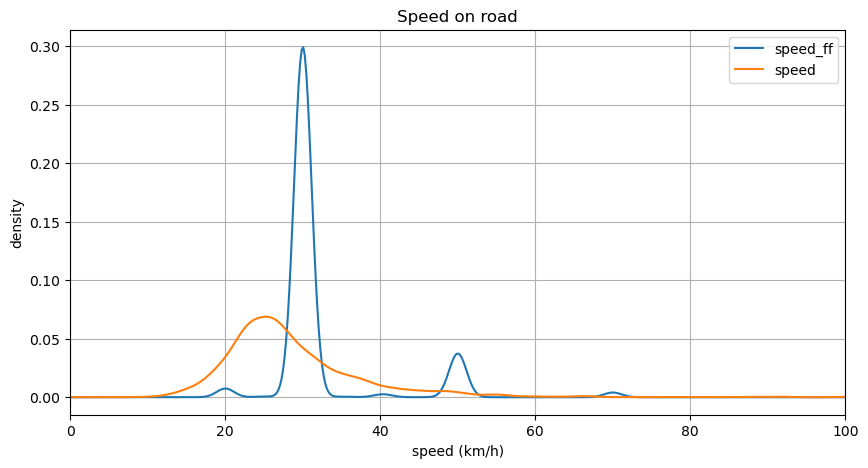

In [604]:
if plot:
    fig, ax = plt.subplots(figsize=(10,5))
    import scipy.stats as stats
    x=np.linspace(0, 100, 500)
    density = stats.gaussian_kde(self.road_links['speed_ff'])
    plt.plot(x,density(x))
    density = stats.gaussian_kde(self.road_links[np.isfinite(self.road_links['speed'])]['speed'])
    plt.plot(x,density(x))
    plt.grid(True,'major',linestyle='-',axis='both')
    ax.set_axisbelow(True)
    plt.xlim([0,100])
    plt.legend(['speed_ff', 'speed'])
    plt.xlabel('speed (km/h)')
    plt.ylabel('density')

    plt.title('Speed on road')
    #plt.savefig(figdir + 'speed_hist.png')
    plt.show()

In [605]:
self.road_links['jam_factor'] = self.road_links['speed']/self.road_links['speed_ff']

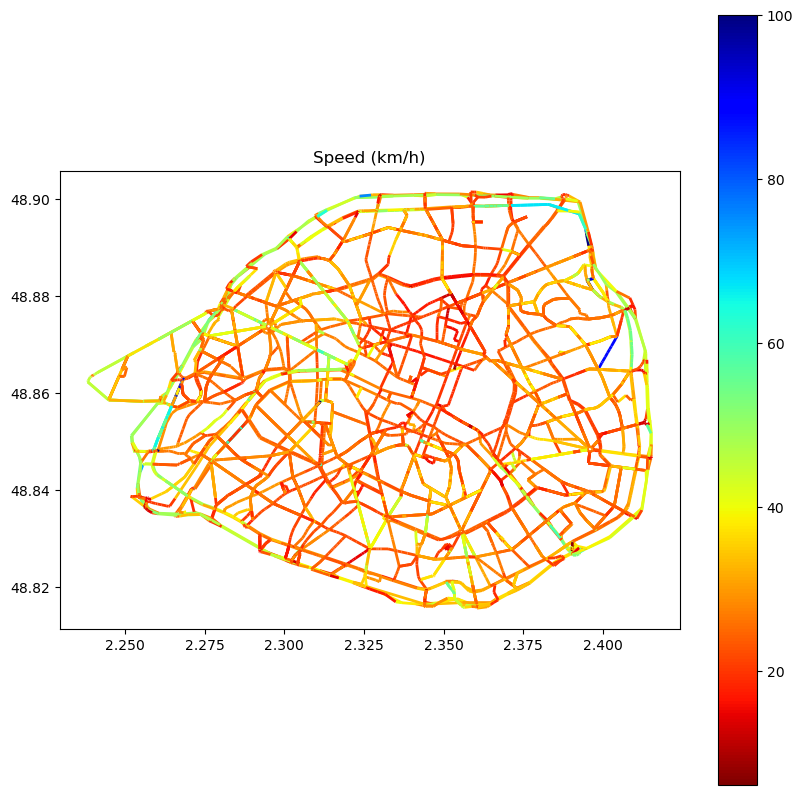

In [606]:
if plot:  
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(10,10))

    self.road_links.plot(ax=ax,column='speed',legend=True,linewidth=2,cmap='jet_r')
    plt.title('Speed (km/h)')

    #plt.xlim([xmin,xmax])
    #plt.ylim([ymin,ymax])
    #plt.savefig(figdir + 'speed_map.png')


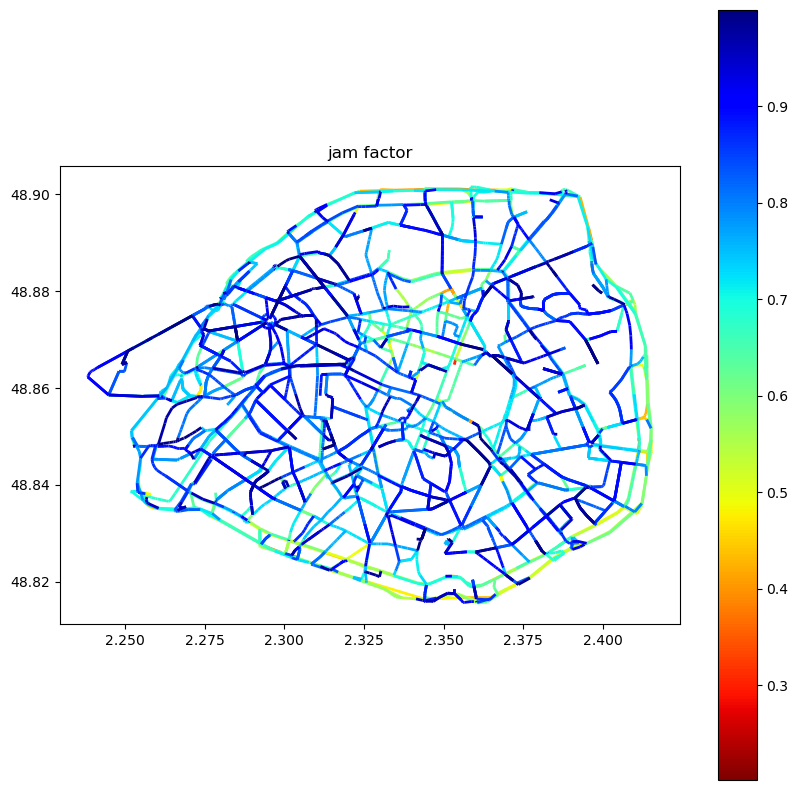

In [607]:
if plot:  
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(10,10))

    self.road_links[self.road_links['jam_factor']<=1].sort_values('jam_factor').plot(ax=ax,column='jam_factor',legend=True,linewidth=2,cmap='jet_r')
    plt.title('jam factor')

    #plt.xlim([xmin,xmax])
    #plt.ylim([ymin,ymax])
    #plt.savefig(figdir + 'jam_factor.png')





# Variogramme

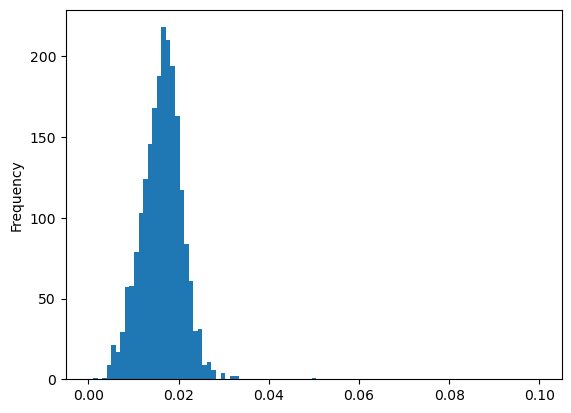

In [608]:
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
#od_time['residual'] = od_time['time'] - od_time['time_ff']
train_df = self.od_time[~self.od_time['interpolated']]

nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(train_df[['o_lon','o_lat','d_lon','d_lat']].values)
indices =  nbrs.kneighbors(train_df[['o_lon','o_lat','d_lon','d_lat']],return_distance=False)
indices = pd.DataFrame(indices)
#distances = pd.DataFrame(distances)
indices = pd.DataFrame(indices.stack(), columns=['index_nn']).reset_index().rename(
    columns={'level_0': 'ix_one', 'level_1': 'rank'})
# drop duplicates (if 100 is neigh to 1, 1 will be neigh to 100, remove all values like that)
# as the index are sorted, index_nn should always be larger than ix_one
indices = indices.loc[(indices['index_nn']>indices['ix_one']).values]

#get euclidien distance (knn distance was wrong (or i applied it wrong))

geom_dict = {i:ls for i, ls in enumerate(train_df[['o_lon','o_lat','d_lon','d_lat']].values)}
indices['geom_one'] = indices['ix_one'].apply(lambda x: geom_dict.get(x))
indices['geom_nn'] = indices['index_nn'].apply(lambda x: geom_dict.get(x))
def get_dist(A,B):
    dist=[]
    for a,b in zip(A,B):
        dist.append(((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2 +(a[3]-b[3])**2)**0.5)
    return dist
indices['distance'] = get_dist(indices['geom_one'],indices['geom_nn'])


res_dict = train_df.reset_index()['residual'].to_dict()
indices['res_one'] = indices['ix_one'].apply(lambda x: res_dict.get(x))
indices['res_nn'] = indices['index_nn'].apply(lambda x: res_dict.get(x))


# difference en variance (time_one-time_ff) - (time_nn-time_ff) **2
indices['res_diff'] = (indices['res_one']-indices['res_nn'])**2

bins=np.linspace(0,0.1,100)
indices['distance'].plot.hist(bins=bins)


bins=100
bins_vols = int(np.ceil(len(indices)/bins))
bins_list = list(range(bins)) * bins_vols
bins_list = bins_list[0:len(indices)]
bins_list.sort()

indices = indices.sort_values('distance')
indices['bins'] = bins_list
try:
    indices = indices.drop(columns=['geom_one','geom_nn'])
except:
    pass

gdf = indices.groupby('bins')[['res_diff']].agg(np.mean)
gdf = gdf/2
bins_name = indices.groupby('bins')['distance'].agg(np.mean).to_dict()
gdf['distance'] = gdf.index.map(bins_name.get) #name bins



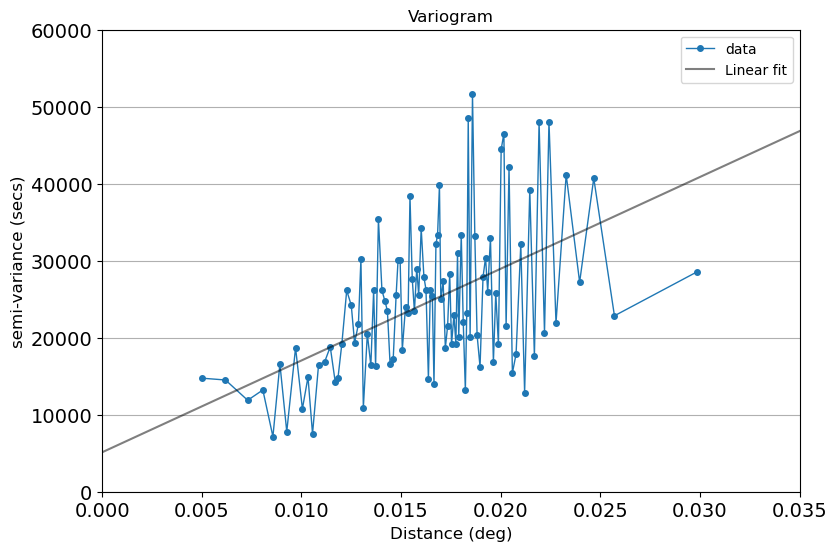

1191841.1431534486 5123.2981446214435


In [609]:
if plot:
    from sklearn import linear_model

    f, ax = plt.subplots(figsize=(9,6))
    x=gdf['distance']
    y=gdf['res_diff'].values


    ax.plot(x, y,'-o', linewidth=1, markersize=4)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True,'major',linestyle='-',axis='y')
    ax.set_axisbelow(True)
    plt.xlabel('Distance (deg)',fontsize=12)
    plt.ylabel('semi-variance (secs)',fontsize=12)
    plt.title('Variogram',fontsize=12)

    plt.ylim([0,60000])
    plt.xlim([0,0.035])


    regr = linear_model.LinearRegression(fit_intercept=True)#
    regr.fit(np.array(x[0:gdf[gdf['distance']<=1000].index[-1]])[:, np.newaxis], y[0:gdf[gdf['distance']<=1000].index[-1]])
    slope = regr.coef_[0]
    intercept = regr.intercept_
    x_fit = np.linspace(0,0.1,100)
    x_lin = x_fit
    y_lin = x_fit*slope+intercept
    plt.plot(x_fit,x_fit*slope+intercept,'k',alpha=0.5)
    plt.legend(['data','Linear fit'])
    #plt.savefig(figdir + 'variogram.png')
    plt.show()
    print(slope,intercept)
